### ***Droge*** : A drug authentication detector

 **Future updates**


*   Extract Nafdac number, check against dataset to get validity
*   Display information on the drug
*   Improve Accuracy






Layer 'output_layer' expected 2 variables, but received 0 variables during loading. Expected: ['kernel', 'bias']

List of objects that could not be loaded:
[<Conv2DTranspose name=output_layer, built=True>]
Continuing with partially loaded weights...
Please select an image file to authenticate


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Saving WhatsApp Image 2025-01-16 at 00.48.31_e540ded2.jpg to WhatsApp Image 2025-01-16 at 00.48.31_e540ded2 (3).jpg


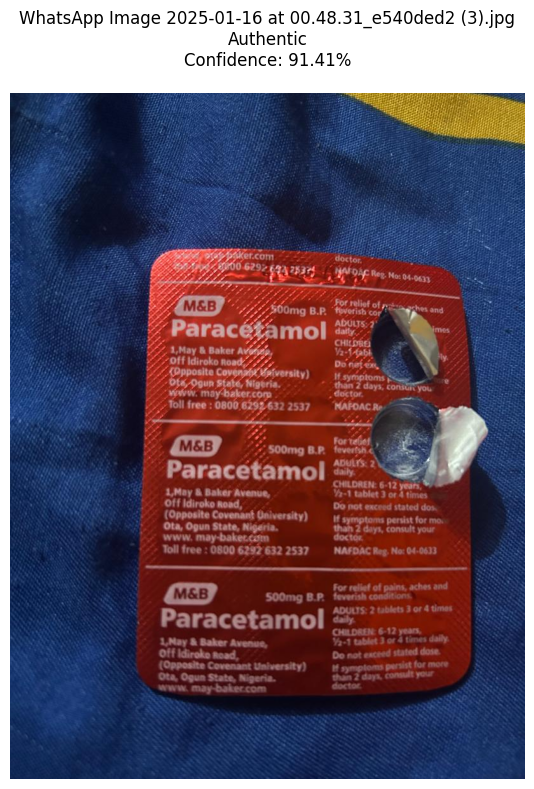

In [65]:
model_weights_path = '/content/drive/MyDrive/colab_data/paracetamol_auth/trained_model.weights.h5'
run_authentication(model_weights_path)

In [61]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2DTranspose, Reshape
from tensorflow.keras.models import Model
import cv2
import numpy as np
from pathlib import Path
import os
from typing import Optional, List, Union
from google.colab import drive, files
import matplotlib.pyplot as plt
from PIL import Image
import io
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
class Authenticator:
    def __init__(self, base_path: str = './data'):
        self.base_path = Path(base_path)
        self.image_size = (224, 224)
        self.threshold = 0.9
        self.setup_model()
        self.model.compile(optimizer='adam', loss='mse')

    def setup_model(self):
        """Setup of autoencoder model with proper dimensionality"""
        input_img = Input(shape=(*self.image_size, 3))
        base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_img)
        base_model.trainable = False

        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(512, activation='relu')(x)
        encoded = Dense(128, activation='relu', name='encoder_output')(x)
        x = Dense(512, activation='relu', kernel_initializer='glorot_uniform')(encoded)
        x = Dense(7 * 7 * 256, activation='relu', kernel_initializer='glorot_uniform')(x)
        x = Reshape((7, 7, 256))(x)

        x = Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu', kernel_initializer='glorot_uniform')(x)
        x = Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu', kernel_initializer='glorot_uniform')(x)
        x = Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu', kernel_initializer='glorot_uniform')(x)
        x = Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation='relu', kernel_initializer='glorot_uniform')(x)
        x = Conv2DTranspose(8, (3, 3), strides=2, padding='same', activation='relu', kernel_initializer='glorot_uniform')(x)

        decoded = Conv2DTranspose(3, (3, 3), padding='same', activation='sigmoid',name='output_layer',
                                  kernel_initializer='glorot_uniform',bias_initializer='zeros')(x)

        self.model = Model(input_img, decoded)
        # print("successfully created model architecture  ")
        # self.model.summary()

    def preprocess_image(self, image: np.ndarray) -> np.ndarray:
        """Preprocess an image for model input"""
        image = cv2.resize(image, self.image_size)
        if len(image.shape) == 2:  #
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        elif image.shape[2] == 4:
            image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
        image = image.astype('float32') / 255.0
        return image

    def authenticate_image(self, image: np.ndarray) -> dict:
        """Authenticate a single image using reconstruction error"""
        preprocessed_image = self.preprocess_image(image)
        img_batch = np.expand_dims(preprocessed_image, axis=0)
        reconstructed = self.model.predict(img_batch, verbose=0)
        reconstruction_error = np.mean(np.square(img_batch - reconstructed))
        confidence = 1.0 / (1.0 + reconstruction_error)
        reconstructed_image = (reconstructed[0] * 255).astype(np.uint8)

        return {
            'is_authentic': confidence > self.threshold,
            'confidence': confidence,
            'reconstruction_error': reconstruction_error,
            'reconstructed_image': reconstructed_image
        }

In [63]:
class ImageAuthenticator:
    def __init__(self, base_model_path: Optional[str] = None):
        self.authenticator = Authenticator()
        if base_model_path:
            self._load_model_weights(base_model_path)

    def _load_model_weights(self, model_path: str):
        """Load model weights with error handling"""
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model weights file not found: {model_path}")
        try:
            self.authenticator.model.load_weights(model_path)
            print("Model weights loaded successfully.")
        except Exception as e:
            print(f"Warning: Some weights could not be loaded: {str(e)}")
            print("Continuing with partially loaded weights...")

    def authenticate_files(self, image_paths: Union[str, List[str]]) -> List[dict]:
        """
        Authenticate one or multiple image files

        Args:
            image_paths: Single image path or list of image paths

        Returns:
            List of authentication results for each image
        """
        if isinstance(image_paths, str):
            image_paths = [image_paths]

        results = []
        for img_path in image_paths:
            try:
                image = cv2.imread(img_path)
                if image is None:
                    raise ValueError(f"Could not read image: {img_path}")

                result = self.authenticator.authenticate_image(image)
                result['image_path'] = img_path
                results.append(result)

            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
                results.append({
                    'image_path': img_path,
                    'error': str(e),
                    'is_authentic': False,
                    'confidence': 0.0
                })

        return results

In [64]:
class ImageProcess(ImageAuthenticator):
    def process_uploaded_image(self):
        """Handle image upload and authentication in Colab"""
        print("Please select an image file to authenticate")
        uploaded = files.upload()

        for filename, content in uploaded.items():
            image_pil = Image.open(io.BytesIO(content))
            image_np = np.array(image_pil)

            if len(image_np.shape) == 3:
                image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)

            # Authenticate image
            result = self.authenticator.authenticate_image(image_np)

            # Visualize results
            self.display_results(image_np, result, filename)

    def display_results(self, original_image, result, filename):
        """Display the original image and authentication results"""
        plt.figure(figsize=(10, 8))

        # Original image
        plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')

        # Display authentication results
        status = "Authentic" if result['is_authentic'] else " Not Authentic"
        confidence = f"Confidence: {result['confidence']:.2%}"

        plt.title(f"{filename}\n{status}\n{confidence}", pad=20)
        plt.tight_layout()
        plt.show()

def run_authentication(model_weights_path):
    authenticator = ImageProcess(base_model_path=model_weights_path)
    authenticator.process_uploaded_image()